In [3]:
import numpy as np
import random as r
from enum import Enum
import collections

EMPTY = 0
SNAKE = 1
FOOD = 2

class GameState(Enum):
    PLAYING = "playing"     # Game is ongoing (includes moments right after food collection)
    GAME_OVER = "game_over" # Snake collision with wall or itself
    WIN = "win"            # Board is full/max score reached


class SnakeGame:
    def __init__(self, board_size=10):
        self.board_size = board_size
        self.board = np.zeros((board_size, board_size))
        self.snake_position = collections.deque([(board_size//2, board_size//2)])  # ordered!
        self.food_position = self._pick_food_position()
        self._update_board_food()
        self._update_board_snake()
        self.game_state = GameState.PLAYING
        self.score = 0
        self.head_history = collections.deque(maxlen=4) # Tracks the last 4 head positions

    def _pick_food_position(self):
        available_positions = set((x, y) 
            for x in range(self.board_size) 
            for y in range(self.board_size)) - set(self.snake_position)
        
        if not available_positions:
            return None  # Game is won - board is full
            
        return r.choice(list(available_positions))
    
    def _clear_board(self):
        self.board = np.zeros((self.board_size, self.board_size))
    
    def _update_board_snake(self):
        for x, y in self.snake_position:
            self.board[x][y] = SNAKE

    def _update_board_food(self):
        if self.food_position:
            x, y = self.food_position
            self.board[x][y] = FOOD

    def reset(self, seed=None):
        if seed is not None:
            r.seed(seed)
        self.game_state = GameState.PLAYING
        self.score = 0
        self.snake_position = collections.deque([(self.board_size // 2, self.board_size // 2)])
        self.food_position = self._pick_food_position()
        self._clear_board()
        self._update_board_snake()
        self._update_board_food()
        self.head_history = collections.deque(maxlen=4) # Tracks the last 4 head positions
        return self.get_state()
    
    def step(self, action):
        head_x, head_y = self.snake_position[-1]
        old_dist = abs(head_x - self.food_position[0]) + abs(head_y - self.food_position[1])
        new_head = self._move_snake(action)
        will_eat_food = (new_head == self.food_position)

        # --- Check for both conditions before calculating rewards ---
        is_biting_neck = new_head in list(self.snake_position)[-3:] # Your logic
        is_waffling = new_head in self.head_history # The new logic
        
        if self._check_collision(new_head, will_eat_food):
            self.game_state = GameState.GAME_OVER
            reward = -10
            return self.get_state(), reward, True, {"score": self.score, "game_state": self.game_state.value}
        
        if will_eat_food:
            reward = 10
            self.score += 1
            self.snake_position.append(new_head)
            self.food_position = self._pick_food_position()
            if not self.food_position:
                self.game_state = GameState.WIN
                reward = 50
                done = True
            else:
                done = False
        else:
            self.snake_position.append(new_head)
            self.snake_position.popleft()
            reward = -0.01  # Light step penalty
            new_dist = abs(new_head[0] - self.food_position[0]) + abs(new_head[1] - self.food_position[1])
            if new_dist < old_dist:
                reward += 0.1 / max(1, len(self.snake_position))  # Scale by length
            else:
                reward -= 0.15 / max(1, len(self.snake_position))
            done = False

            # Penalize loops
            # --- Combine the penalties ---
            if is_biting_neck:
                reward -= 0.4 # Your existing penalty
            
            if is_waffling:
                reward -= 0.5 # The new behavioral loop penalty

            # Update snake position and history
            self.snake_position.append(new_head)
            self.snake_position.popleft()
            self.head_history.append(new_head) # Add new head to history
            
            done = False
        
        self._clear_board()
        self._update_board_snake()
        self._update_board_food()
        
        return self.get_state(), reward, done, {
            "score": self.score,
            "game_state": self.game_state.value,
            "snake_length": len(self.snake_position)
        }
    
    def _move_snake(self, action):
        """
        Calculate new head position based on action
        Args:
            action: int (0: up, 1: right, 2: down, 3: left)
        Returns:
            tuple: (x, y) coordinates of new head position
        """
        # Get current head position (last added position)
        head_x, head_y = self.snake_position[-1]
        
        # Calculate new head position based on action
        if action == 0:    # up
            new_head = (head_x - 1, head_y)
        elif action == 1:  # right
            new_head = (head_x, head_y + 1)
        elif action == 2:  # down
            new_head = (head_x + 1, head_y)
        else:             # left
            new_head = (head_x, head_y - 1)
        
        return new_head

    def _check_collision(self, new_head, will_eat_food = False):
        x, y = new_head
        
        # Check wall collision
        if x < 0 or x >= self.board_size or y < 0 or y >= self.board_size:
            return True
        
        # For self collision, exclude tail if not eating food
        snake_body_to_check = self.snake_position
        if not will_eat_food:
            # Exclude tail from collision check since it will move
            snake_body_to_check = list(self.snake_position)[1:]  # Skip tail (index 0)
        
        if new_head in snake_body_to_check:
            return True
        
        return False
    
    def get_state(self):
        """
        Return current state for RL agent
        Returns:
            numpy array: Current board state
        """
        return np.copy(self.board)

    # Add this method for testing/debugging:
    def print_board(self):
        """Print a visual representation of the current game state"""
        symbols = {EMPTY: '-', SNAKE: '*', FOOD: '@'}
        for row in self.board:
            print(' '.join(symbols[int(cell)] for cell in row))
        print(f"Score: {self.score}, Snake length: {len(self.snake_position)}")
        print()

In [71]:
class SnakeGameLen1(SnakeGame):
    def step(self, action):
        """
        Execute one time step within the environment.
        The snake length always stays 1.
        """
        reward = 0
        new_head = self._move_snake(action)

        # Check collision with wall or itself (should only check wall)
        x, y = new_head
        if x < 0 or x >= self.board_size or y < 0 or y >= self.board_size:
            self.game_state = GameState.GAME_OVER
            reward = -10
            return self.get_state(), reward, True, {
                "score": self.score,
                "game_state": self.game_state.value,
                "snake_length": 1
            }

        # Check if food is eaten
        will_eat_food = (new_head == self.food_position)
        self.snake_position.clear()
        self.snake_position.append(new_head)

        if will_eat_food:
            self.score += 1
            reward = 10
            self.food_position = self._pick_food_position()
            if not self.food_position:
                self.game_state = GameState.WIN
                reward = 50
                self._clear_board()
                self._update_board_snake()
                self._update_board_food()
                return self.get_state(), reward, True, {
                    "score": self.score,
                    "game_state": self.game_state.value,
                    "snake_length": 1
                }

        self._clear_board()
        self._update_board_snake()
        self._update_board_food()

        return self.get_state(), reward, False, {
            "score": self.score,
            "game_state": self.game_state.value,
            "snake_length": 1
        }

In [14]:
from collections import defaultdict
import random

# Define this function before the class
def default_q_values():
    return [0.0, 0.0, 0.0, 0.0]

class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=0.5):
        self.learning_rate = learning_rate  # α
        self.discount_factor = discount_factor  # γ  
        self.epsilon = epsilon
        self.q_table = defaultdict(default_q_values)  # 4 actions
    
    def get_state_key(self, game, last_action):
        head_x, head_y = game.snake_position[-1]
        tail_x, tail_y = game.snake_position[0]
        food_x, food_y = game.food_position if game.food_position else (-1, -1)
        
        point_l = (head_x, head_y - 1)
        point_r = (head_x, head_y + 1)
        point_u = (head_x - 1, head_y)
        point_d = (head_x + 1, head_y)
        
        dir_l = last_action == 3
        dir_r = last_action == 1
        dir_u = last_action == 0
        dir_d = last_action == 2
        
        food_left = food_y < head_y if game.food_position else 0
        food_right = food_y > head_y if game.food_position else 0
        food_up = food_x < head_x if game.food_position else 0
        food_down = food_x > head_x if game.food_position else 0
        
        tail_left = tail_y < head_y
        tail_right = tail_y > head_y
        tail_up = tail_x < head_x
        tail_down = tail_x > head_x
        
        snake_len_bin = min(2, (len(game.snake_position) - 1) // 5)

        # Wall distances
        dist_left = head_y
        dist_right = game.board_size - 1 - head_y
        dist_up = head_x
        dist_down = game.board_size - 1 - head_x
        
        dist_left = min(2, dist_left // 2)
        dist_right = min(2, dist_right // 2)
        dist_up = min(2, dist_up // 2)
        dist_down = min(2, dist_down // 2)
        
        # --- NEW: Wall Distance Features ---
        # Calculate raw distance to each of the four walls
        dist_to_left_wall = head_y
        dist_to_right_wall = game.board_size - 1 - head_y
        dist_to_top_wall = head_x
        dist_to_bottom_wall = game.board_size - 1 - head_x

        # Discretize the distances to keep the state space manageable.
        # For a 5x5 board, we can bin them into 3 levels: 0 (on edge), 1 (1 away), 2 (2+ away)
        dist_left_bin = min(2, dist_to_left_wall)
        dist_right_bin = min(2, dist_to_right_wall)
        dist_up_bin = min(2, dist_to_top_wall)
        dist_down_bin = min(2, dist_to_bottom_wall)
        
        state = [
            (dir_r and game._check_collision(point_r, False)) or
            (dir_l and game._check_collision(point_l, False)) or
            (dir_u and game._check_collision(point_u, False)) or
            (dir_d and game._check_collision(point_d, False)),
            (dir_u and game._check_collision(point_r, False)) or
            (dir_d and game._check_collision(point_l, False)) or
            (dir_l and game._check_collision(point_u, False)) or
            (dir_r and game._check_collision(point_d, False)),
            (dir_d and game._check_collision(point_r, False)) or
            (dir_u and game._check_collision(point_l, False)) or
            (dir_r and game._check_collision(point_u, False)) or
            (dir_l and game._check_collision(point_d, False)),
            dir_l, dir_r, dir_u, dir_d,
            food_left, food_right, food_up, food_down,
            tail_left, tail_right, tail_up, tail_down,
            snake_len_bin,
            dist_left, dist_right, dist_up, dist_down,
            dist_up_bin,
            dist_down_bin,
            dist_left_bin,
            dist_right_bin
        ]
        return tuple(map(int, state))  # Ensure tuple of integers
        
    def choose_action(self, state_key, game):
        q_values = self.q_table[state_key]
        safe_actions = []
        
        for action in range(4):
            new_head = game._move_snake(action)
            if not game._check_collision(new_head, False) and \
            not (hasattr(self, 'last_action') and action == (self.last_action + 2) % 4):
                safe_actions.append(action)
        
        if not safe_actions:  # Cornered, pick any
            safe_actions = list(range(4))
        
        if random.random() < self.epsilon:
            action = random.choice(safe_actions)
        else:
            # Choose best action among safe ones, or random if none safe
            best_actions = safe_actions if safe_actions else list(range(4))
            max_q = max(q_values[i] for i in best_actions)
            best_actions = [i for i in best_actions if q_values[i] == max_q]
            action = random.choice(best_actions)
        
        self.last_action = action
        return action
    
    def update_q_value(self, state, action, reward, next_state):
        """
        Update Q-value for state-action pair using Q-learning formula
        Args:
            state: tuple of current state
            action: int of action taken
            reward: float of reward received
            next_state: tuple of next state
        """
        # Get current Q-value
        current_q = self.q_table[state][action]
        
        # Get maximum Q-value for next state
        next_max_q = max(self.q_table[next_state])
        
        # Apply Q-learning formula
        # Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * next_max_q - current_q
        )
        
        # Update Q-table
        self.q_table[state][action] = new_q

In [ ]:
def train_agent(num_episodes=500, max_steps=200, board_size=10):
    """
    Train the Q-learning agent
    Args:
        num_episodes: Number of episodes to train
        max_steps: Maximum steps per episode
        board_size: Size of the game board
    Returns:
        scores: List of scores achieved in each episode
        avg_scores: List of running average scores
    """
    # Initialize game and agent
    game = SnakeGame(board_size=board_size)
    agent = QLearningAgent(learning_rate=0.1, discount_factor=0.99, epsilon=1)
    
    # Training statistics
    scores = []
    avg_scores = []
    running_avg = 0
    
    for episode in range(num_episodes):
        # Reset environment
        game.reset()
        episode_score = 0

        # The snake starts stationary, so we can pick a default like 'up' (0).
        last_action = 0 
        
        for step in range(max_steps):
            # Get current state
            current_state = agent.get_state_key(game, last_action)
            
            # Choose action
            current_action = agent.choose_action(current_state, game)

            # Take action
            next_board, reward, done, info = game.step(current_action)

            # Get next state
            next_state = agent.get_state_key(game, current_action)
            
            # Update Q-values
            agent.update_q_value(current_state, current_action, reward, next_state)
            
            # Update last action
            last_action = current_action

            # Update episode score
            episode_score += reward
            
            # Break if game is over
            if done:
                break
        
        # Update statistics
        scores.append(episode_score)
        running_avg = sum(scores[-100:]) / min(len(scores), 100)  # Last 100 episodes
        avg_scores.append(running_avg)
        
        # Print progress every 10 episodes
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Score: {episode_score}, "
                  f"Avg Score: {running_avg:.2f}, Epsilon: {agent.epsilon:.2f}")
        
        # Decay epsilon for less exploration over time
        agent.epsilon = max(0.05, agent.epsilon * 0.999)
    
    return agent, scores, avg_scores

# Train the agent
agent, scores, avg_scores = train_agent(num_episodes=10000, max_steps=200, board_size=5)

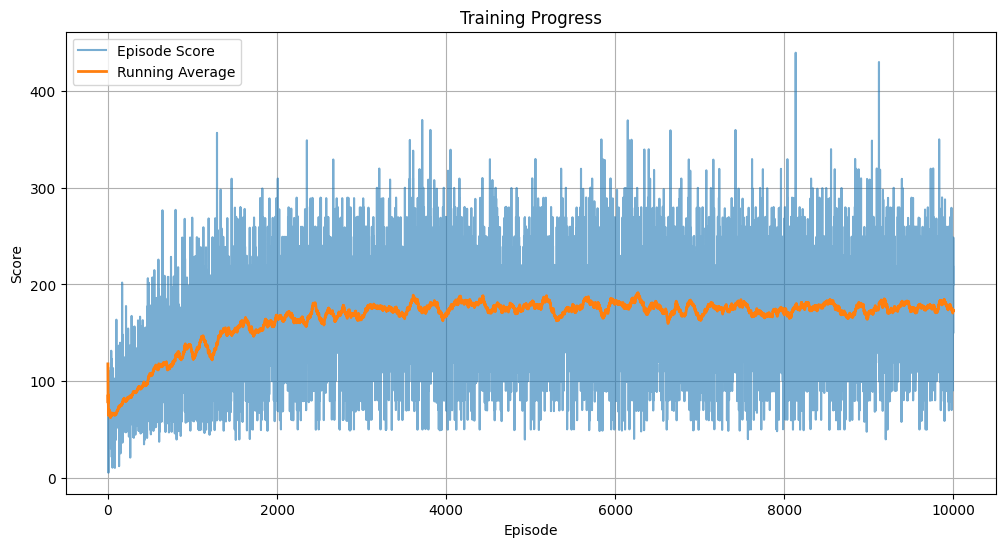

In [16]:
# Optional: Visualize training progress using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(scores, label='Episode Score', alpha=0.6)
plt.plot(avg_scores, label='Running Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Save the trained agent (optional)
import pickle

with open('trained_snake_q_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

In [17]:
# Run analysis
analyze_agent_behavior_det(agent, SnakeGame(board_size=5))


Detailed Agent Analysis:

agent: <__main__.QLearningAgent object at 0x10c572160>
board_size: 5
Action Distribution:
Up: 24.8% (Avg consecutive: 0.5)
Right: 25.2% (Avg consecutive: 0.6)
Down: 24.8% (Avg consecutive: 0.6)
Left: 25.3% (Avg consecutive: 0.5)

Performance Metrics:
Food Collection Rate: 19.32 per episode
Average Episode Length: 92.0 steps
Death Rate: 99.6%

Death Analysis:
Deaths while moving Up: 26.3%
Deaths while moving Right: 27.3%
Deaths while moving Down: 24.9%
Deaths while moving Left: 21.5%


{'action_distribution': [(0, 0.24776067484129055, 0.5444015444015444),
  (1, 0.2517610226976259, 0.56286701208981),
  (2, 0.24776067484129055, 0.5521235521235521),
  (3, 0.25271762761979305, 0.549036476256022)],
 'food_collection_rate': 19.32,
 'avg_episode_length': 91.992,
 'death_rate': 0.996,
 'death_directions': [(0, 0.26305220883534136),
  (1, 0.27309236947791166),
  (2, 0.24899598393574296),
  (3, 0.21485943775100402)]}

In [12]:
import random
import numpy as np

def analyze_agent_behavior_det(agent, game, num_episodes=500, seed=42, max_steps=1000):
    random.seed(seed)
    np.random.seed(seed)
    agent.epsilon = 0  # Greedy policy for deterministic evaluation
    action_counts = [0, 0, 0, 0]
    death_positions = []
    food_collected = 0
    episode_lengths = []
    consecutive_actions = [0, 0, 0, 0]
    last_action = None
    
    for episode in range(num_episodes):
        game.reset(seed=episode)  # Seed reset for consistency
        done = False
        steps = 0
        episode_food = 0
        
        while not done and steps < max_steps:
            state = agent.get_state_key(game, last_action if last_action is not None else 0)
            action = agent.choose_action(state, game)
            
            if action == last_action:
                consecutive_actions[action] += 1
            last_action = action
            
            action_counts[action] += 1
            steps += 1
            
            _, reward, done, info = game.step(action)
            if reward == 10:
                food_collected += 1
                episode_food += 1
            if done and reward == -10:
                death_positions.append((game.snake_position[0], action))
                # if action == 1 or action == 3:  # Right or Left
                #     print(f"{'Right' if action == 1 else 'Left'} death at {game.snake_position[0]}, board:")
                #     game.print_board()
        
        episode_lengths.append(steps)
    
    total_actions = sum(action_counts)
    print("\nDetailed Agent Analysis:\n")
    print("agent:", agent)
    print("board_size:", game.board_size)
    print("Action Distribution:")
    for i, count in enumerate(action_counts):
        print(f"{'Up' if i == 0 else 'Right' if i == 1 else 'Down' if i == 2 else 'Left'}: "
              f"{count / total_actions * 100:.1f}% "
              f"(Avg consecutive: {consecutive_actions[i] / max(1, count):.1f})")
    
    print("\nPerformance Metrics:")
    print(f"Food Collection Rate: {food_collected / num_episodes:.2f} per episode")
    print(f"Average Episode Length: {sum(episode_lengths) / num_episodes:.1f} steps")
    print(f"Death Rate: {len(death_positions) / num_episodes * 100:.1f}%")
    
    print("\nDeath Analysis:")
    for i in range(4):
        count = sum(1 for _, a in death_positions if a == i)
        print(f"Deaths while moving {'Up' if i == 0 else 'Right' if i == 1 else 'Down' if i == 2 else 'Left'}: "
              f"{count / max(1, len(death_positions)) * 100:.1f}%")
    
    return {
        "action_distribution": [(i, count / total_actions, consecutive_actions[i] / max(1, count))
                               for i, count in enumerate(action_counts)],
        "food_collection_rate": food_collected / num_episodes,
        "avg_episode_length": sum(episode_lengths) / num_episodes,
        "death_rate": len(death_positions) / num_episodes,
        "death_directions": [(i, sum(1 for _, a in death_positions if a == i) / max(1, len(death_positions)))
                            for i in range(4)]
    }

In [ ]:
analysis1 = analyze_agent_behavior_det(agent, SnakeGame(board_size=5), num_episodes=500, seed=42)
analysis2 = analyze_agent_behavior_det(agent, SnakeGame(board_size=5), num_episodes=500, seed=42)
print("Identical results:", analysis1 == analysis2)

In [6]:
import random
import collections

# A helper function needed for saving/loading the agent
def default_q_values():
    return [0.0, 0.0, 0.0, 0.0]

class DoubleQLearningAgent:
    """
    An agent that uses Double Q-Learning to mitigate overestimation bias.
    """
    def __init__(self, learning_rate, discount_factor, epsilon):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        # We now maintain two Q-tables
        self.q_table_a = collections.defaultdict(default_q_values)
        self.q_table_b = collections.defaultdict(default_q_values)
        self.last_action = 0

    # In the DoubleQLearningAgent class...
    def get_state_key(self, game, last_action):
        # This is the full, advanced state representation from your QLearningAgent
        head_x, head_y = game.snake_position[-1]
        tail_x, tail_y = game.snake_position[0]
        food_x, food_y = game.food_position if game.food_position else (-1, -1)
        
        point_l = (head_x, head_y - 1)
        point_r = (head_x, head_y + 1)
        point_u = (head_x - 1, head_y)
        point_d = (head_x + 1, head_y)
        
        dir_l = last_action == 3
        dir_r = last_action == 1
        dir_u = last_action == 0
        dir_d = last_action == 2
        
        food_left = food_y < head_y if game.food_position else 0
        food_right = food_y > head_y if game.food_position else 0
        food_up = food_x < head_x if game.food_position else 0
        food_down = food_x > head_x if game.food_position else 0
        
        tail_left = tail_y < head_y
        tail_right = tail_y > head_y
        tail_up = tail_x < head_x
        tail_down = tail_x > head_x
        
        snake_len_bin = min(2, (len(game.snake_position) - 1) // 5)
        
        # --- DYNAMIC WALL DISTANCE CALCULATION ---
        # Calculate a dynamic maximum bin based on board size.
        max_bin_dist = int(game.board_size / 2)

        dist_to_left_wall = head_y
        dist_to_right_wall = game.board_size - 1 - head_y
        dist_to_top_wall = head_x
        dist_to_bottom_wall = game.board_size - 1 - head_x

        # Use the dynamic max_bin_dist instead of a hardcoded number.
        dist_left_bin = min(max_bin_dist, dist_to_left_wall)
        dist_right_bin = min(max_bin_dist, dist_to_right_wall)
        dist_up_bin = min(max_bin_dist, dist_to_top_wall)
        dist_down_bin = min(max_bin_dist, dist_to_bottom_wall)
        
        state = [
            (dir_r and game._check_collision(point_r, False)) or
            (dir_l and game._check_collision(point_l, False)) or
            (dir_u and game._check_collision(point_u, False)) or
            (dir_d and game._check_collision(point_d, False)),
            (dir_u and game._check_collision(point_r, False)) or
            (dir_d and game._check_collision(point_l, False)) or
            (dir_l and game._check_collision(point_u, False)) or
            (dir_r and game._check_collision(point_d, False)),
            (dir_d and game._check_collision(point_r, False)) or
            (dir_u and game._check_collision(point_l, False)) or
            (dir_r and game._check_collision(point_u, False)) or
            (dir_l and game._check_collision(point_d, False)),
            dir_l, dir_r, dir_u, dir_d,
            food_left, food_right, food_up, food_down,
            tail_left, tail_right, tail_up, tail_down,
            snake_len_bin,
            dist_left_bin, dist_right_bin, dist_up_bin, dist_down_bin
        ]
        return tuple(map(int, state))

    def choose_action(self, state_key, game):
        """Chooses an action based on the average of both Q-tables for more stable decisions."""
        if random.random() < self.epsilon:
            # Exploration logic remains the same
            possible_actions = list(range(4))
            random.shuffle(possible_actions)
            for action in possible_actions:
                if len(game.snake_position) > 1 and action == (self.last_action + 2) % 4:
                    continue
                new_head = game._move_snake(action)
                if not game._check_collision(new_head):
                    self.last_action = action
                    return action
            return random.choice(possible_actions)
        else:
            # Exploitation: Use the sum of Q-values from both tables
            q_values_a = self.q_table_a[state_key]
            q_values_b = self.q_table_b[state_key]
            sum_q_values = [a + b for a, b in zip(q_values_a, q_values_b)]
            
            action = max(range(len(sum_q_values)), key=sum_q_values.__getitem__)
            self.last_action = action
            return action

    def update_q_value(self, state, action, reward, next_state):
        """
        Updates one of the two Q-tables randomly using the Double Q-Learning rule.
        """
        # Randomly choose which table to update (A or B)
        if random.random() < 0.5:
            # Update Q_A using value from Q_B
            best_action_in_next_state = max(range(4), key=self.q_table_a[next_state].__getitem__)
            next_q_value = self.q_table_b[next_state][best_action_in_next_state]
            
            current_q = self.q_table_a[state][action]
            new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q_value - current_q)
            self.q_table_a[state][action] = new_q
        else:
            # Update Q_B using value from Q_A
            best_action_in_next_state = max(range(4), key=self.q_table_b[next_state].__getitem__)
            next_q_value = self.q_table_a[next_state][best_action_in_next_state]
            
            current_q = self.q_table_b[state][action]
            new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q_value - current_q)
            self.q_table_b[state][action] = new_q

In [ ]:
# --- Training Configuration ---
LEARNING_RATE_START = 0.3
LEARNING_RATE_END = 0.05
DECAY_STEPS = [25000, 40000] # Episodes at which to decay learning rate

EPSILON_START = 1.0
EPSILON_DECAY = 0.99992
EPSILON_MIN = 0.05

BOARD_SIZE = 5
NUM_EPISODES = 100000
MAX_STEPS_PER_EPISODE = 500


def train_agent_og_double_q(num_episodes=500, max_steps=200, board_size=10):
    """
    Train the Q-learning agent
    Args:
        num_episodes: Number of episodes to train
        max_steps: Maximum steps per episode
        board_size: Size of the game board
    Returns:
        scores: List of scores achieved in each episode
        avg_scores: List of running average scores
    """
    # Initialize game and agent
    game = SnakeGame(board_size=board_size)
    agent = DoubleQLearningAgent(learning_rate=0.3, discount_factor=0.99, epsilon=1)
    
    # Training statistics
    scores = []
    avg_scores = []
    running_avg = 0
    
    for episode in range(num_episodes):
        # Reset environment
        game.reset()
        episode_score = 0

        # The snake starts stationary, so we can pick a default like 'up' (0).
        last_action = 0 
        
        for step in range(max_steps):
            # Get current state
            current_state = agent.get_state_key(game, last_action)
            
            # Choose action
            current_action = agent.choose_action(current_state, game)

            # Take action
            next_board, reward, done, info = game.step(current_action)

            # Get next state
            next_state = agent.get_state_key(game, current_action)
            
            # Update Q-values
            agent.update_q_value(current_state, current_action, reward, next_state)
            
            # Update last action
            last_action = current_action

            # Update episode score
            episode_score += reward
            
            # Break if game is over
            if done:
                break
        
        # Update statistics
        scores.append(episode_score)
        running_avg = sum(scores[-100:]) / min(len(scores), 100)  # Last 100 episodes
        avg_scores.append(running_avg)
        
        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Score: {episode_score}, "
                  f"Avg Score: {running_avg:.2f}, Epsilon: {agent.epsilon:.2f}")
        
        # NEW: Step Decay for Learning Rate
        if episode + 1 in DECAY_STEPS:
            agent.learning_rate *= 0.5 # Halve the learning rate
            print(f"\\n--- Episode {episode + 1}: Learning rate decayed to {agent.learning_rate:.4f} ---\\n")

        # Decay epsilon for less exploration over time
        agent.epsilon = max(0.05, agent.epsilon * 0.99992)
    
    return agent, scores, avg_scores

# Train the agent
agent, scores, avg_scores = train_agent_og_double_q(num_episodes=NUM_EPISODES, max_steps=MAX_STEPS_PER_EPISODE, board_size=BOARD_SIZE)

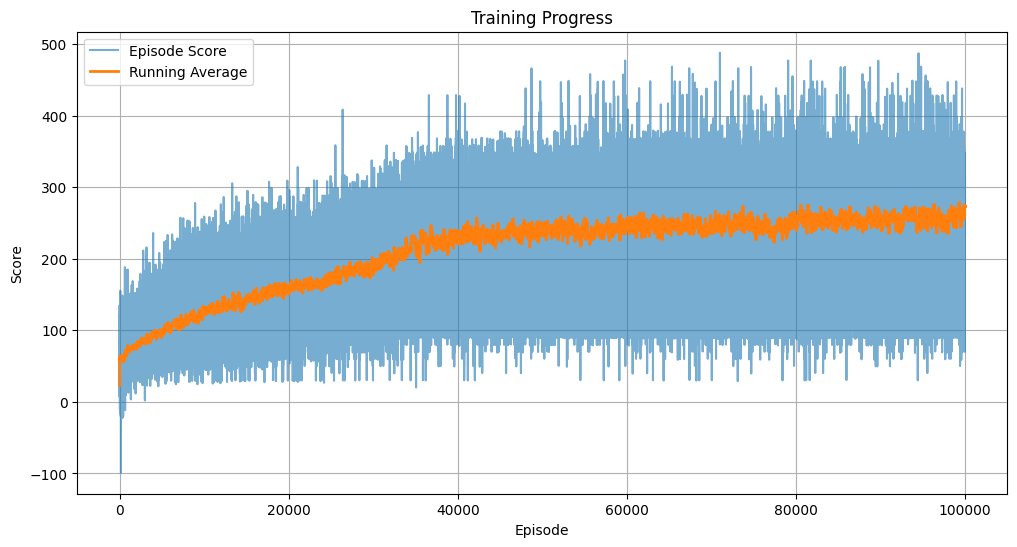

In [8]:
# Optional: Visualize training progress using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(scores, label='Episode Score', alpha=0.6)
plt.plot(avg_scores, label='Running Average', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Save the trained agent (optional)
import pickle

with open('trained_snake_double_q_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

In [11]:
analyze_agent_behavior_det(agent, SnakeGame(board_size=BOARD_SIZE), num_episodes=500, seed=42)


Detailed Agent Analysis:

agent: <__main__.DoubleQLearningAgent object at 0x109a1ae50>
board_size: 5
Action Distribution:
Up: 24.6% (Avg consecutive: 0.6)
Right: 25.4% (Avg consecutive: 0.6)
Down: 24.6% (Avg consecutive: 0.6)
Left: 25.4% (Avg consecutive: 0.6)

Performance Metrics:
Food Collection Rate: 27.56 per episode
Average Episode Length: 652.2 steps
Death Rate: 43.6%

Death Analysis:
Deaths while moving Up: 27.1%
Deaths while moving Right: 21.1%
Deaths while moving Down: 35.8%
Deaths while moving Left: 16.1%


{'action_distribution': [(0, 0.24617455673921976, 0.6315848478431471),
  (1, 0.2538070443352775, 0.6215083123912624),
  (2, 0.24585870851808922, 0.6099705647575334),
  (3, 0.25415969040741354, 0.6453193055270683)],
 'food_collection_rate': 27.556,
 'avg_episode_length': 652.212,
 'death_rate': 0.436,
 'death_directions': [(0, 0.2706422018348624),
  (1, 0.21100917431192662),
  (2, 0.3577981651376147),
  (3, 0.16055045871559634)]}

In [86]:
import pickle

# Define the path to your saved agent file
agent_path = 'trained_snake_agent.pkl'

# Load the agent object from the file
try:
    with open(agent_path, 'rb') as f:
        loaded_agent = pickle.load(f)
    print(f"Agent successfully loaded from {agent_path}")
except FileNotFoundError:
    print(f"Error: No agent file found at {agent_path}")
except Exception as e:
    print(f"An error occurred while loading the agent: {e}")

agent = loaded_agent

analyze_agent_behavior_det(agent, SnakeGame(board_size=BOARD_SIZE), num_episodes=500, seed=42)

Agent successfully loaded from trained_snake_agent.pkl

Detailed Agent Analysis:

agent: <__main__.DoubleQLearningAgent object at 0x11a5f9790>
board_size: 5
Action Distribution:
Up: 25.9% (Avg consecutive: 0.6)
Right: 24.1% (Avg consecutive: 0.6)
Down: 25.9% (Avg consecutive: 0.6)
Left: 24.1% (Avg consecutive: 0.6)

Performance Metrics:
Food Collection Rate: 28.35 per episode
Average Episode Length: 726.8 steps
Death Rate: 33.6%

Death Analysis:
Deaths while moving Up: 23.8%
Deaths while moving Right: 35.7%
Deaths while moving Down: 29.8%
Deaths while moving Left: 10.7%


{'action_distribution': [(0, 0.25870513970600373, 0.6396213370206882),
  (1, 0.24141043350962835, 0.601926364983472),
  (2, 0.2586721187872517, 0.6387030201163792),
  (3, 0.24121230799711618, 0.626001049533414)],
 'food_collection_rate': 28.346,
 'avg_episode_length': 726.812,
 'death_rate': 0.336,
 'death_directions': [(0, 0.23809523809523808),
  (1, 0.35714285714285715),
  (2, 0.2976190476190476),
  (3, 0.10714285714285714)]}

In [ ]:
!uv pip install ipywidgets

In [ ]:
import time
import random
from IPython.display import display, clear_output
import ipywidgets as widgets

# Assuming SnakeGame and QLearningAgent classes are defined in previous cells or imported
# from game import SnakeGame
# from agent import QLearningAgent, agent

class InteractivePlayer:
    """
    A self-contained class for creating an interactive Snake game player.
    This version includes a cleanup method to prevent issues with re-running cells.
    """
    def __init__(self, agent, board_size=5):
        self.agent = agent
        self.board_size = board_size
        self._create_widgets()
        self._link_events()

    def _create_widgets(self):
        """Creates all the UI widgets for the player."""
        self.speed_slider = widgets.FloatSlider(
            min=0.05, max=0.5, step=0.05, value=0.1, 
            description='Speed (s):', continuous_update=False
        )
        self.play_button = widgets.Button(
            description="Play New Game",
            button_style='success',
            tooltip='Click to start a new episode playback'
        )
        self.game_output_area = widgets.Output()
        
        # This VBox will hold all our UI elements.
        self.ui_container = widgets.VBox([
            widgets.HTML("<h3>Interactive Episode Player</h3>"),
            self.speed_slider, 
            self.play_button, 
            self.game_output_area
        ])

    def _link_events(self):
        """Links the button's on_click event to the play method."""
        self.play_button.on_click(self._play_episode_handler)

    def _play_episode_handler(self, b):
        """Handles the button click event. Disables the button to prevent multiple runs."""
        self.play_button.disabled = True
        self.game_output_area.clear_output()
        try:
            self._play_episode()
        finally:
            self.play_button.disabled = False

    def _play_episode(self):
        """Runs the actual game loop and animation."""
        game = SnakeGame(board_size=self.board_size)
        game.reset(seed=random.randint(0, 1000))
        done = False
        last_action = 0
        
        while not done:
            with self.game_output_area:
                clear_output(wait=True)
                game.print_board()
            
            state = self.agent.get_state_key(game, last_action)
            action = self.agent.choose_action(state, game)
            _, _, done, _ = game.step(action)
            last_action = action
            time.sleep(self.speed_slider.value)
            
        with self.game_output_area:
            clear_output(wait=True)
            print("--- FINAL STATE ---")
            game.print_board()
            print(f"Game Over! Final Score: {game.score}")

    def display_player(self):
        """Displays the entire UI container."""
        display(self.ui_container)

    def close_widgets(self):
        """
        Explicitly closes all widgets. This is the key to preventing "ghost" widgets
        when the cell is re-run.
        """
        self.speed_slider.close()
        self.play_button.close()
        self.game_output_area.close()
        self.ui_container.close()

# 2. Clear the entire cell's output to start fresh.
clear_output() 

# 3. Create a new, clean instance of our player class.
player = InteractivePlayer(agent=agent, board_size=5)

# 4. Display the new player.
player.display_player()